In [781]:
#Install required package
# %pip install arch


In [782]:
#Required Package
import numpy as np
import pandas as pd
import datetime
import math


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch.unitroot import PhillipsPerron

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


In [839]:
#Import Data

# Read the CSV file into a DataFrame
df = pd.read_csv('SKI.csv')


In [840]:
#Remove unnecessary columns

df.drop(['Chars', 'Chars.1', 'Chars.2', 'Chars.3', 'Chars.4', 'Chars.5', 'Chars.6', 'Chars.7', 'Chars.8','Chars.9', 'Chars.10', 'Chars.11', 'Chars.12', 'Chars.13', 'Chars.14','Chars.15', 'Chars.16', 'Chars.17', 
         'Shapes', 'Shapes.1', 'Shapes.2','Shapes.3', 'Shapes.4', 'Shapes.5', 'Shapes.6', 'Shapes.7', 'Shapes.8','Shapes.9', 'Shapes.10', 'Shapes.11', 'Shapes.12', 'Shapes.13','Shapes.14', 'Shapes.15', 'Shapes.16', 'Shapes.17', 'Shapes.18',
       'Shapes.19', 'Shapes.20', 'Shapes.21', 'Shapes.22', 'Shapes.23','Shapes.24', 'Shapes.25', 'MA','MA.1','MA.2','Smoothing Line','Smoothing Line.1','Smoothing Line.2' ], axis=1, inplace=True)

In [841]:
def fixtime(input_df):
    formatted_dates = []

    for timestamp in input_df['time']:
        date = datetime.datetime.fromtimestamp(timestamp)
        formatted_date = date.strftime("%Y-%m-%d")
        formatted_dates.append(formatted_date)

    input_df['Date'] = formatted_dates
    input_df.drop(columns=['time'], inplace=True)
    
    return input_df


In [842]:
df

,time,open,high,low,close
0,1658707200,166693.030197,170955.067901,166693.030197,170007.948412
1,1658793600,170481.508156,176164.225095,168587.269177,173796.426371
2,1658880000,174269.986115,174743.545860,170481.508156,172849.306881
3,1658966400,175217.105605,177584.904330,169060.828922,172375.747136
4,1659052800,173322.866626,180899.822544,172849.306881,177584.904330
...,...,...,...,...,...
295,1696464000,142000.000000,143300.000000,139200.000000,139500.000000
296,1696550400,139500.000000,141300.000000,138000.000000,138700.000000
297,1696896000,141900.000000,142600.000000,135800.000000,136300.000000
298,1696982400,138900.000000,143400.000000,138200.000000,142800.000000


In [843]:
#Format the dates

df = fixtime(df)

df = df.rename({'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, axis='columns')



In [844]:
#Function for Returns

def treturn(input_df):
    input_df['Return'] = (input_df['Close'] / input_df['Close'].shift(1)) - 1 
    input_df.fillna(0, inplace = True)

    return(input_df)



In [845]:
#Return

df = treturn(df)


In [847]:
#Entry Signals - Benchmark

#Benchmark Based on dollar cost averaging


dca_days = 300
df['BM TS'] = 1
tslist = [i for i in range(len(df)) if i % dca_days != 0]
df.loc[tslist, 'BM TS'] = 0
df['BM Netposition'] = df['BM TS'].cumsum()


In [848]:
#Entry Signal - Trading Signal

#1. Based on One day return of the previous day

move = -.05
df['TS_Entry'] = 0
df.loc[df['Return'].shift(1) < move, 'TS_Entry'] = 1

# #2. Based on 5 day return as of previous close

# cmove = -.2
# df['Rolling Returns'] = df['Return'].rolling(window=40).sum()
# df['Rolling Returns'].fillna(0, inplace=True)
# df['TS 1'] = 0
# trigger_indices = df[df['Rolling Returns'].shift(1) < cmove].index
# df.loc[trigger_indices, 'TS 1'] = 1
# for idx in trigger_indices:
#     df.loc[idx+1:idx+20, 'TS 1'] = 0




In [851]:
#Exit Signals

#For the Benchmark
# df['BM TS Exit'] = 0

#Trading Signal

exit_move = -(move / 1)
df['TS_Exit'] = 0
df.loc[df['Return'].shift(1) > exit_move, 'TS_Exit'] = 1

# Reset 'TS_Exit' values before the first 'TS_Entry' value to 0
first_TS_Entry_index = df.index[df['TS_Entry'].ne(0)].min()
if first_TS_Entry_index is not None:
    df.loc[:first_TS_Entry_index - 1, 'TS_Exit'] = 0


In [852]:
# #Gross / Net Position

# # Initialize columns for 'Gross Long', 'Gross Short', and 'Net Position'
# df['TS Gross Long'] = df['TS_Entry'].cumsum()
# df['TS Gross Short'] = 0
# df['TS Netposition'] = 0

# for i in range(1,len(df)):

#     if df.at[i, 'TS_Exit'] == 1:
#         if df.at[i, 'TS Gross Long'] > 0:
#             df.at[i, 'TS Gross Short'] = df.at[i, 'TS Gross Long'] * .5
#         else:
#             continue
#     else:
#         df.at[i, 'TS Gross Short'] = df.at[i-1, 'TS Gross Short']
    
#     df.at[i, 'TS Netposition'] = df.at[i, 'TS Gross Long'] - df.at[i, 'TS Gross Short']


In [853]:
#Gross / Net Position

# Initialize columns for 'Gross Long', 'Gross Short', and 'Net Position'
df['TS Gross Long'] = df['TS_Entry'].cumsum()
df['TS Gross Short'] = 0
df['TS Netposition'] = 0

for i in range(1,len(df)):

    if df.at[i, 'TS_Exit'] == 1:
        if df.at[i, 'TS Gross Long'] > 0:
            df.at[i, 'TS Gross Short'] = df.at[i-1, 'TS Gross Short'] + (df.at[i-1, 'TS Netposition'] * .5)

        else:
            continue
    else:
        df.at[i, 'TS Gross Short'] = df.at[i-1, 'TS Gross Short']
    
    df.at[i, 'TS Netposition'] = df.at[i-1, 'TS Gross Long'] - df.at[i, 'TS Gross Short']



The number of entry signal is 9 . The number of exit signal is 12
Average Exposure for Benchmark 1.0
Average Exposure for Trading Strategy 0.8662565104166666


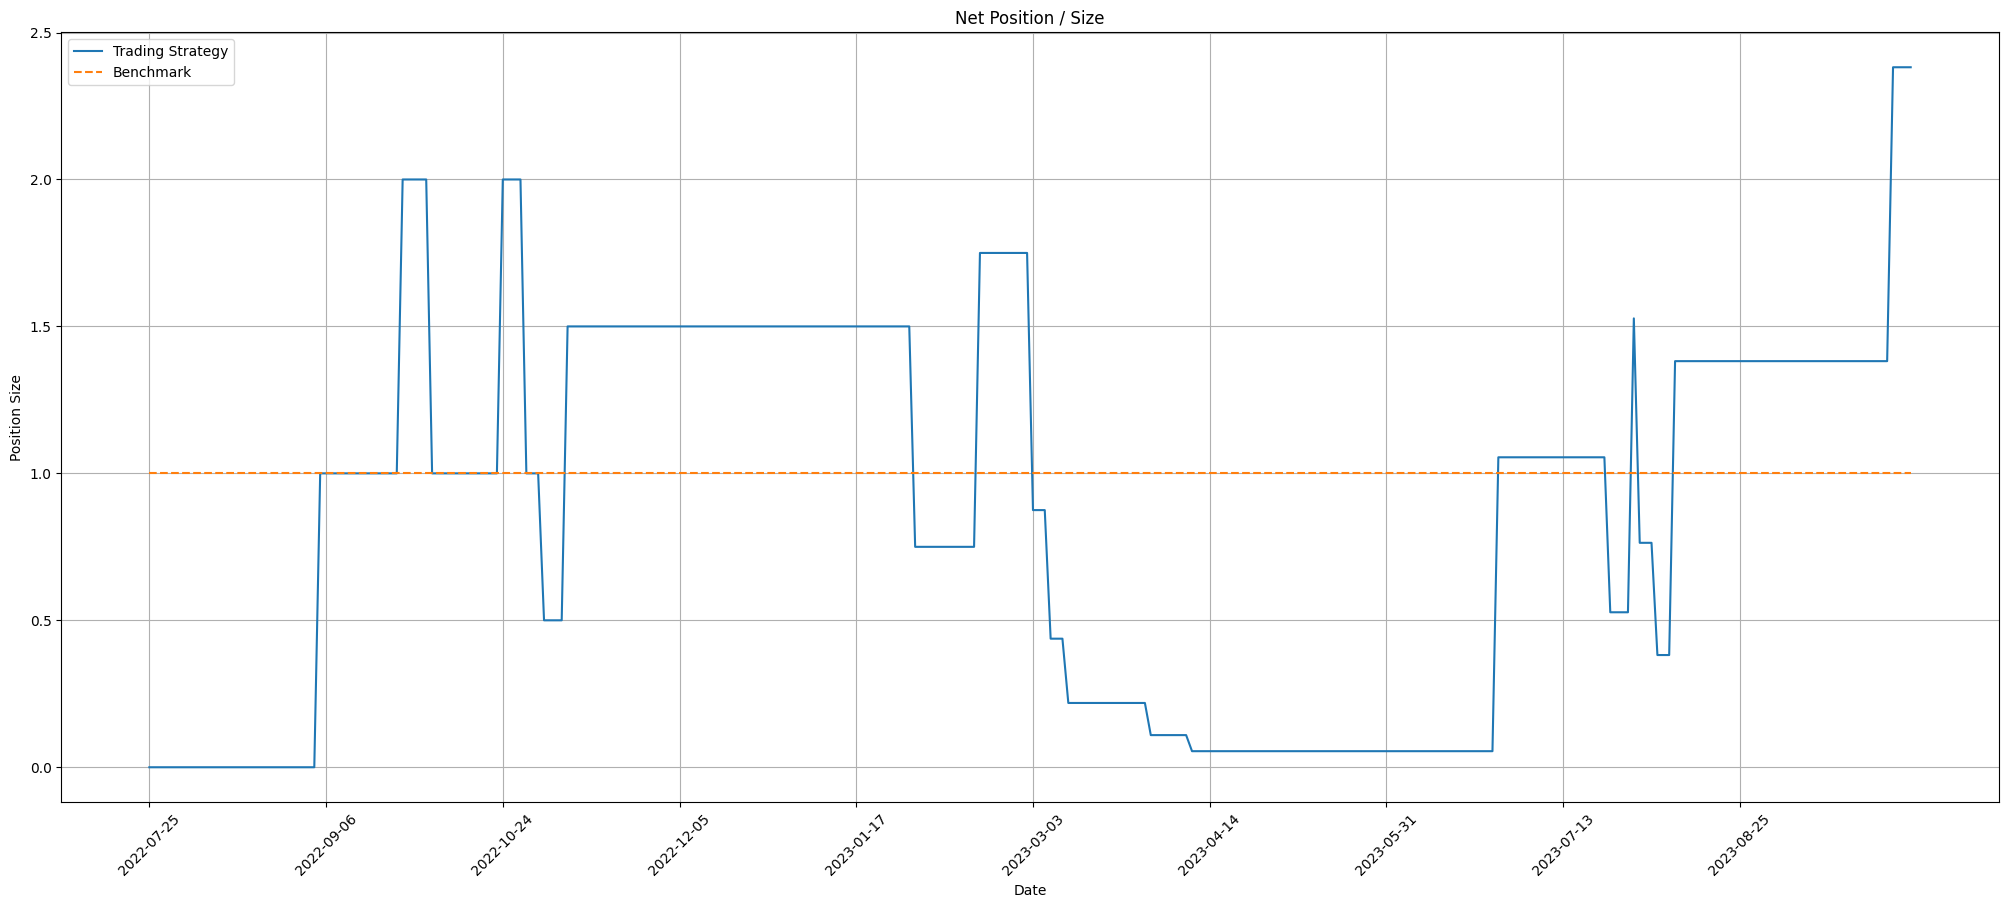

In [854]:
# Assuming 'Date' is a datetime column in your DataFrame

print('The number of entry signal is', df['TS_Entry'].sum(), '. The number of exit signal is', df['TS_Exit'].sum())
print('Average Exposure for Benchmark', df['BM Netposition'].mean())
print('Average Exposure for Trading Strategy', df['TS Netposition'].mean())

plt.figure(figsize=(25, 10))

# Plot TS Absolute and BM Absolute Retruns
plt.plot(df['Date'], df['TS Netposition'], label='Trading Strategy')
plt.plot(df['Date'], df['BM Netposition'], label='Benchmark', linestyle='--')  # You can specify linestyle


plt.xlabel('Date')
plt.ylabel('Position Size')
plt.title('Net Position / Size')
plt.grid(True)
plt.legend()

x_indices = np.arange(0, len(df), 30)
plt.xticks(df['Date'][x_indices], rotation=45)
plt.show()

In [855]:
df

,Open,High,Low,Close,Date,Return,BM TS,BM Netposition,TS_Entry,TS_Exit,TS Gross Long,TS Gross Short,TS Netposition
0,166693.030197,170955.067901,166693.030197,170007.948412,2022-07-25,0.000000,1,1,0,0,0,0.000000,0.000000
1,170481.508156,176164.225095,168587.269177,173796.426371,2022-07-26,0.022284,0,1,0,0,0,0.000000,0.000000
2,174269.986115,174743.545860,170481.508156,172849.306881,2022-07-27,-0.005450,0,1,0,0,0,0.000000,0.000000
3,175217.105605,177584.904330,169060.828922,172375.747136,2022-07-28,-0.002740,0,1,0,0,0,0.000000,0.000000
4,173322.866626,180899.822544,172849.306881,177584.904330,2022-07-29,0.030220,0,1,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,142000.000000,143300.000000,139200.000000,139500.000000,2023-10-05,-0.011339,0,1,1,0,9,6.618164,1.381836
296,139500.000000,141300.000000,138000.000000,138700.000000,2023-10-06,-0.005735,0,1,0,0,9,6.618164,2.381836
297,141900.000000,142600.000000,135800.000000,136300.000000,2023-10-10,-0.017304,0,1,0,0,9,6.618164,2.381836
298,138900.000000,143400.000000,138200.000000,142800.000000,2023-10-11,0.047689,0,1,0,0,9,6.618164,2.381836


In [856]:
df.tail(20)

,Open,High,Low,Close,Date,Return,BM TS,BM Netposition,TS_Entry,TS_Exit,TS Gross Long,TS Gross Short,TS Netposition
280,171600.0,172900.0,169300.0,171000.0,2023-09-08,-0.009844,0,1,0,0,8,6.618164,1.381836
281,170900.0,171600.0,166600.0,167900.0,2023-09-11,-0.018129,0,1,0,0,8,6.618164,1.381836
282,168900.0,171000.0,164700.0,167000.0,2023-09-12,-0.005360,0,1,0,0,8,6.618164,1.381836
283,166000.0,168000.0,159500.0,159900.0,2023-09-13,-0.042515,0,1,0,0,8,6.618164,1.381836
284,160300.0,162300.0,157100.0,162200.0,2023-09-14,0.014384,0,1,0,0,8,6.618164,1.381836
285,161900.0,162600.0,157000.0,159600.0,2023-09-15,-0.016030,0,1,0,0,8,6.618164,1.381836
286,160700.0,167900.0,160600.0,164600.0,2023-09-18,0.031328,0,1,0,0,8,6.618164,1.381836
287,165100.0,167500.0,163800.0,164200.0,2023-09-19,-0.002430,0,1,0,0,8,6.618164,1.381836
288,164200.0,165700.0,162500.0,164400.0,2023-09-20,0.001218,0,1,0,0,8,6.618164,1.381836
289,162500.0,162700.0,158700.0,159000.0,2023-09-21,-0.032847,0,1,0,0,8,6.618164,1.381836


In [857]:
#FUNCTION: Strategy Return

def strat_return(input_df, Net_Position_Col ,strat_col_a,strat_col_b, strat_col_c, ts_type):
    
    #Net Position 
    input_df[Net_Position_Col]
   
    #Strategy Value ("xxx SValue")
    input_df[strat_col_a] = 0
    
    #Strategy Return ("xxx SReturn")
    input_df[strat_col_b] = 0

    #Absolute Return ('xxx AbsReturn)
    input_df[strat_col_c] = 0

    
    for i in range(len(input_df)):

        #Daily Return of the Strategy
        if input_df.at[i, Net_Position_Col ] > 0:
            input_df.at[i, strat_col_b] = input_df.at[i, 'Return']

        if ts_type == 'Short':
            input_df.at[i, strat_col_b] = input_df.at[i, strat_col_b] * -1 
                
        #Daily Strategy Value
        if input_df.at[i, Net_Position_Col ] > 0:
            if i == 0:
                if input_df.at[i, Net_Position_Col ] == 1:
                    input_df.at[i, strat_col_a] = 1
                else:
                    pass
            elif input_df.at[i-1, strat_col_a] == 0:
                input_df.at[i, strat_col_a] = 1 * (1+ input_df.at[i, strat_col_b])
            else:
                new_inv = input_df.at[i, Net_Position_Col ] - input_df.at[i-1, Net_Position_Col ] 
                input_df.at[i, strat_col_a] = (input_df.at[i-1, strat_col_a]+ new_inv) * (1+ input_df.at[i, strat_col_b])

        #Daily Absoulte Return
        input_df.at[i, strat_col_c] = input_df.at[i, strat_col_a] - input_df.at[i, Net_Position_Col]
    
    input_df.fillna(0, inplace = True)
    


In [858]:
strat_return(df, 'BM Netposition', 'BM SValue', 'BM SReturn', 'BM AbsReturn', "Long")

strat_return(df, 'TS Netposition', 'TS SValue', 'TS SReturn', 'TS AbsReturn', "Long")



In [859]:
df

,Open,High,Low,Close,Date,Return,BM TS,BM Netposition,TS_Entry,TS_Exit,TS Gross Long,TS Gross Short,TS Netposition,BM SValue,BM SReturn,BM AbsReturn,TS SValue,TS SReturn,TS AbsReturn
0,166693.030197,170955.067901,166693.030197,170007.948412,2022-07-25,0.000000,1,1,0,0,0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,170481.508156,176164.225095,168587.269177,173796.426371,2022-07-26,0.022284,0,1,0,0,0,0.000000,0.000000,1.022284,0.022284,0.022284,0.000000,0.000000,0.000000
2,174269.986115,174743.545860,170481.508156,172849.306881,2022-07-27,-0.005450,0,1,0,0,0,0.000000,0.000000,1.016713,-0.005450,0.016713,0.000000,0.000000,0.000000
3,175217.105605,177584.904330,169060.828922,172375.747136,2022-07-28,-0.002740,0,1,0,0,0,0.000000,0.000000,1.013928,-0.002740,0.013928,0.000000,0.000000,0.000000
4,173322.866626,180899.822544,172849.306881,177584.904330,2022-07-29,0.030220,0,1,0,0,0,0.000000,0.000000,1.044568,0.030220,0.044568,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,142000.000000,143300.000000,139200.000000,139500.000000,2023-10-05,-0.011339,0,1,1,0,9,6.618164,1.381836,0.820550,-0.011339,-0.179450,1.291344,-0.011339,-0.090492
296,139500.000000,141300.000000,138000.000000,138700.000000,2023-10-06,-0.005735,0,1,0,0,9,6.618164,2.381836,0.815844,-0.005735,-0.184156,2.278203,-0.005735,-0.103633
297,141900.000000,142600.000000,135800.000000,136300.000000,2023-10-10,-0.017304,0,1,0,0,9,6.618164,2.381836,0.801727,-0.017304,-0.198273,2.238782,-0.017304,-0.143054
298,138900.000000,143400.000000,138200.000000,142800.000000,2023-10-11,0.047689,0,1,0,0,9,6.618164,2.381836,0.839961,0.047689,-0.160039,2.345547,0.047689,-0.036289


In [860]:
#FUNCTION: Compute the number of days each trade takes to become positive. 


def trade_days(input_df, strat_inv_column):
    #Dataframe to collect the number of days each trade took to become positive
    data = {'Trade': [0, 0],'Trade Date': [0, 0],'Purchase Price': [0, 0], 'Positive Close': [0, 0], 'Positive Date': [0,0], 'Days to Positive': [0,0]}
    trade_df = pd.DataFrame(data)

    #Initialize Values
    new_trade = 0
    trade_days = 0
    positive_trade = 0
    trade_number = 0
        
    for i in range(len(input_df)):
        
        #Register a new trade
        if i == 0:
            if input_df.at[i, strat_inv_column] == 1:
               new_trade = 1
               trade_number += 1
        else:
            if input_df.at[i, strat_inv_column] - input_df.at[i-1, strat_inv_column] == 1:
                new_trade = 1
                trade_number += 1
        
        # If there is a new trade, find the days it takes to reach positive value
        if new_trade == 1:
            purchase_price = input_df.at[i, 'Close']
        
            for a in range(len(input_df)-i):
                
                trade_days += 1

                if input_df.at[a+i, 'Close'] > purchase_price:
                    positive_trade = 1
                    trade_df.at[trade_number, 'Trade'] = trade_number
                    trade_df.at[trade_number, 'Trade Date'] = i
                    trade_df.at[trade_number, 'Purchase Price'] = purchase_price
                    trade_df.at[trade_number, 'Positive Close'] = input_df.at[a+i, 'Close']
                    trade_df.at[trade_number, 'Positive Date'] = a+i
                    trade_df.at[trade_number, 'Days to Positive'] = trade_days-1
                    
                    #Reset values
                    new_trade = 0
                    positive_trade = 0
                    trade_days = 0
                    break
                else:
                    pass

            
        else:
            pass

    trade_df = trade_df.iloc[1:]
    
    return(trade_df)
                

In [861]:
BM_trade_df = trade_days(df, 'BM Netposition')
TS_trade_df = trade_days(df, 'TS Netposition')

In [862]:
BM_trade_df

,Trade,Trade Date,Purchase Price,Positive Close,Positive Date,Days to Positive
1,1,0,170007.948412,173796.426371,1,1


In [863]:
TS_trade_df

,Trade,Trade Date,Purchase Price,Positive Close,Positive Date,Days to Positive
1,1.0,29.0,176164.225095,177584.904330,30.0,1.0
2,2.0,43.0,143015.042953,145856.401423,47.0,4.0
3,3.0,60.0,146803.520912,161010.313259,63.0,3.0
4,4.0,71.0,175217.105605,183320.841600,169.0,98.0
5,5.0,141.0,156978.263400,158643.036000,143.0,2.0
6,6.0,229.0,157369.974600,160111.953000,232.0,3.0
7,7.0,253.0,203200.185000,206500.000000,255.0,50.0
8,8.0,263.0,179400.000000,179500.000000,264.0,159.0
9,9.0,296.0,138700.000000,142800.000000,298.0,2.0


Benchmark is Long once every 300 days
Entry Signal if daily return is less than -0.05
Exit signals are generated after the first Entry Signal and if the prices move 0.05


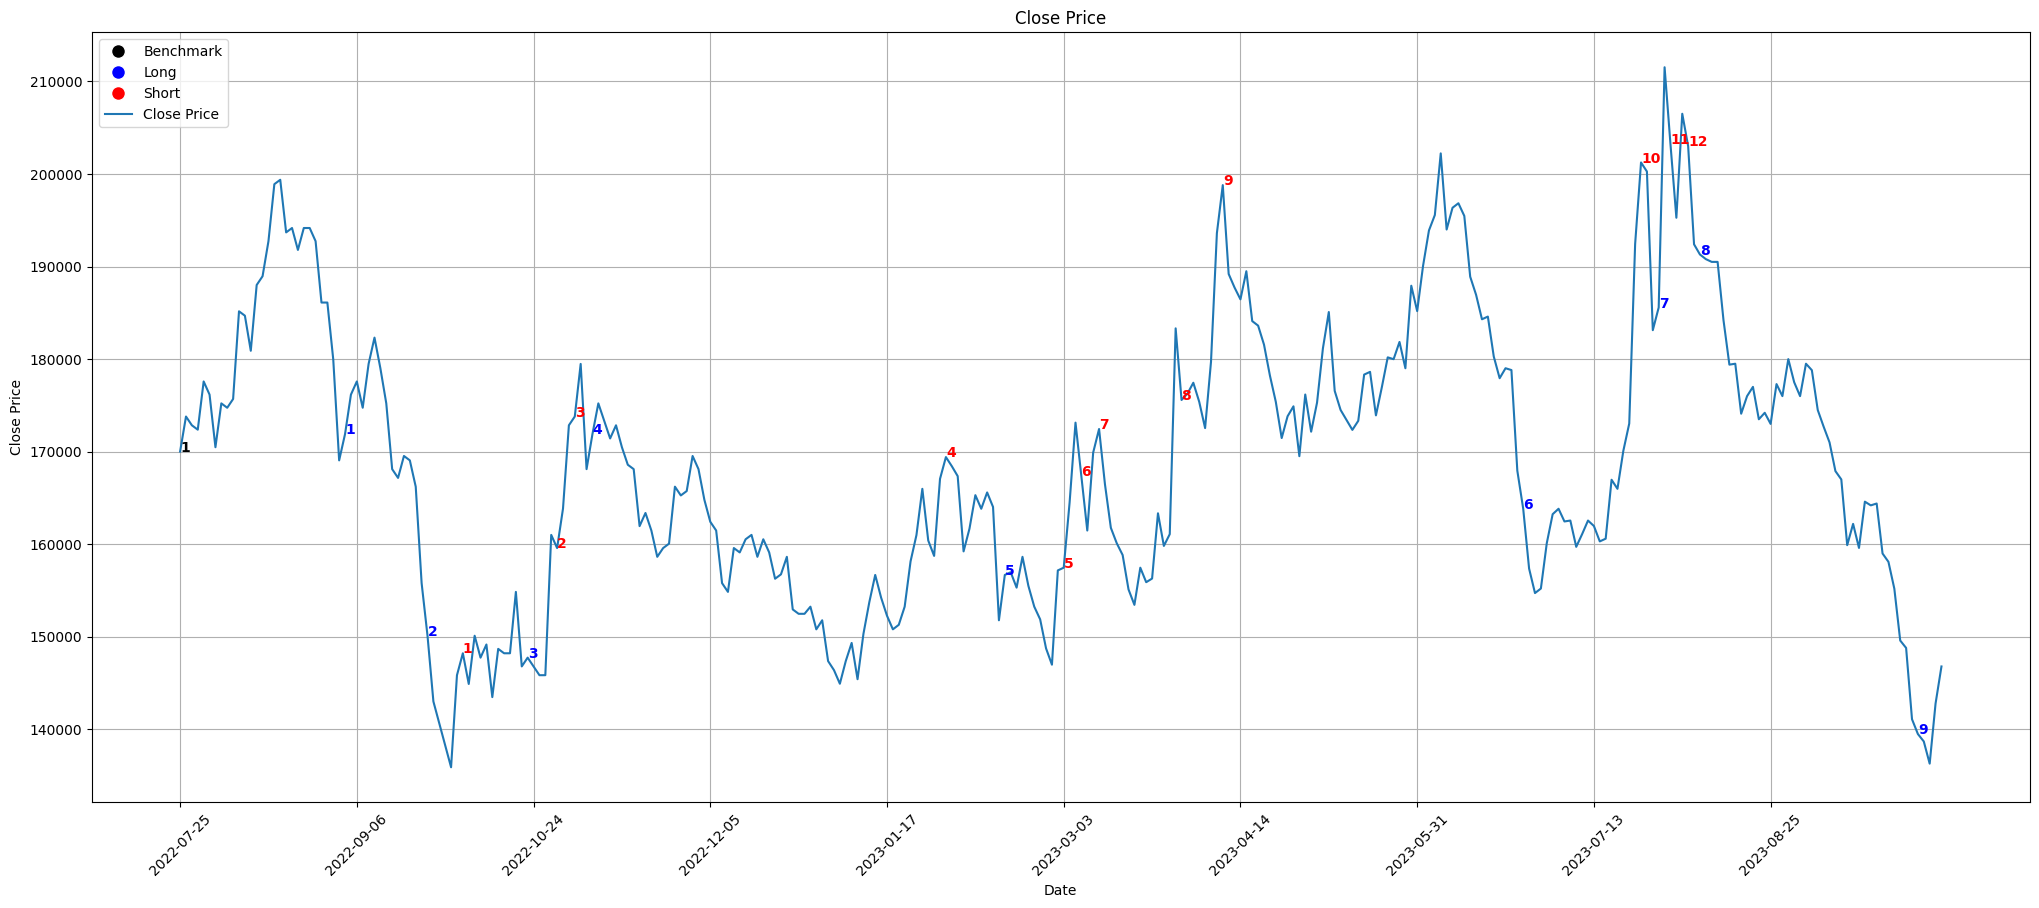

In [867]:
# Assuming 'Date' is a datetime column in your DataFrame


print('Benchmark is Long once every', dca_days, 'days')
print('Entry Signal if daily return is less than', move) 
print('Exit signals are generated after the first Entry Signal and if the prices move', exit_move)

plt.figure(figsize=(25, 10))

# Plot 'TS1 PValue'
plt.plot(df['Date'], df['Close'], label='Close Price')

bm_ts_count = 0
ts_entry = 0
ts_exit = 0


bm_marker = Line2D([0], [0], marker='o', color='w', label='Benchmark',
                   markerfacecolor='black', markersize=10)
long_marker = Line2D([0], [0], marker='o', color='w', label='Long',
                     markerfacecolor='blue', markersize=10)
short_marker = Line2D([0], [0], marker='o', color='w', label='Short',
                      markerfacecolor='red', markersize=10)

for i, date in enumerate(df['Date']):
    if df['BM TS'].iloc[i] == 1:
        bm_ts_count += 1
        plt.text(date, df['Close'].iloc[i] + 0.02, str(bm_ts_count), fontsize=10, color='black', fontweight='bold')
    if df['TS_Entry'].iloc[i] == 1:
        ts_entry += 1
        plt.text(date, df['Close'].iloc[i] + 0.02, str(ts_entry), fontsize=10, color='blue', fontweight='bold')
    if df['TS_Exit'].iloc[i] == 1:
        ts_exit += 1
        plt.text(date, df['Close'].iloc[i] + 0.02, str(ts_exit), fontsize=10, color='red', fontweight='bold')


plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price')
plt.grid(True)
plt.legend()

legend_elements = [bm_marker, long_marker, short_marker]
plt.legend(handles=legend_elements+ [line], loc='upper left')

x_indices = np.arange(0, len(df), 30)
plt.xticks(df['Date'][x_indices], rotation=45)
plt.show()

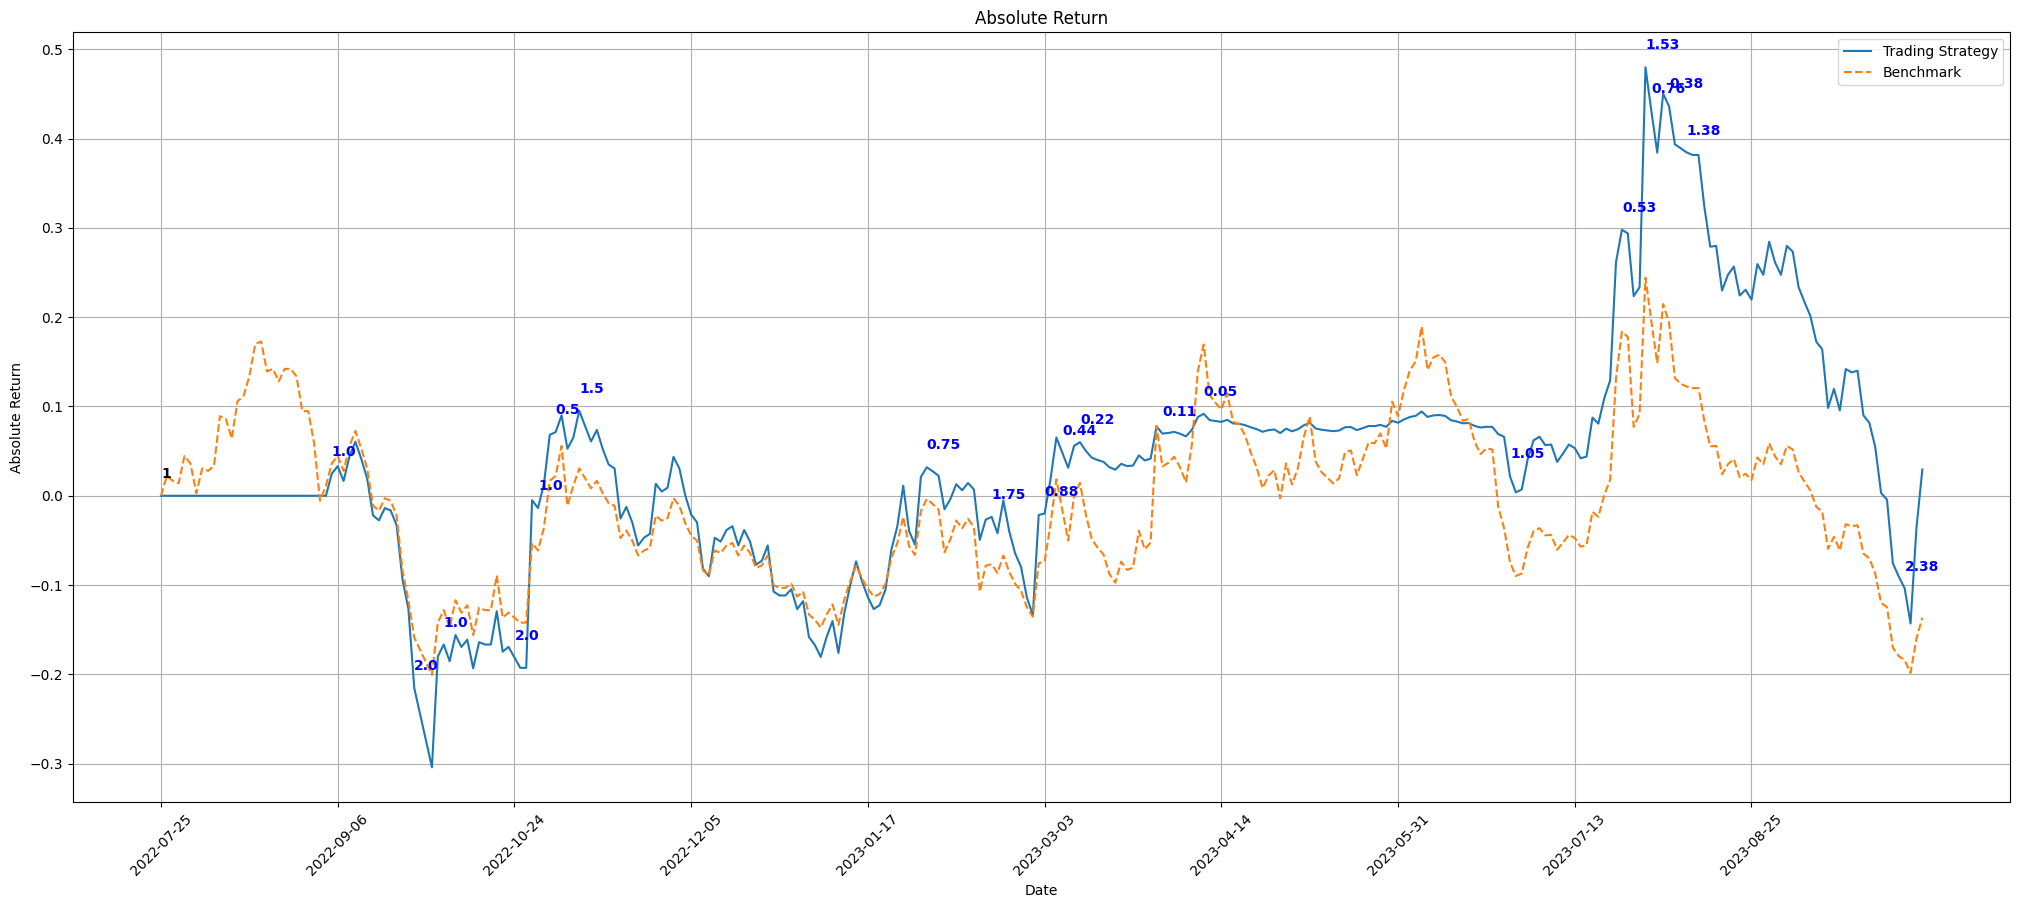

In [881]:
# Assuming 'Date' is a datetime column in your DataFrame
plt.figure(figsize=(25, 10))

# Plot 'TS PValue'
plt.plot(df['Date'], df['TS AbsReturn'], label='Trading Strategy')

# Plot 'CReturns'
plt.plot(df['Date'], df['BM AbsReturn'], label='Benchmark', linestyle='--')  # You can specify linestyle

bm_ts_count = 0
ts_entry = 0
ts_exit = 0

prev_net_position = None  # Initialize previous net position as None

for i, date in enumerate(df['Date']):
    current_net_position = df['TS Netposition'].iloc[i]

    if df['BM TS'].iloc[i] == 1:
        bm_ts_count += 1
        plt.text(date, df['BM AbsReturn'].iloc[i] + 0.02, str(bm_ts_count), fontsize=10, color='black', fontweight='bold')

    if current_net_position != prev_net_position and i != 0:  # Check for a change in net position
        ts_entry = current_net_position  # Update the count to the current net position
        ts_entry = round(ts_entry,2)
        plt.text(date, df['TS AbsReturn'].iloc[i] + 0.02, str(ts_entry), fontsize=10, color='blue', fontweight='bold')
    
    prev_net_position = current_net_position

plt.xlabel('Date')
plt.ylabel('Absolute Return')
plt.title('Absolute Return')
plt.grid(True)
plt.legend()

x_indices = np.arange(0, len(df), 30)
plt.xticks(df['Date'][x_indices], rotation=45)
plt.show()

In [834]:
# # Assuming 'Date' is a datetime column in your DataFrame
# plt.figure(figsize=(25, 10))

# # Plot TS Absolute and BM Absolute Retruns
# plt.plot(df['Date'], df['TS CReturn'], label='Trading Strategy')
# plt.plot(df['Date'], df['BM CReturn'], label='Benchmark', linestyle='--')  # You can specify linestyle

# bm_ts_count = 0
# ts_entry = 0
# ts_exit = 0

# prev_net_position = None  # Initialize previous net position as None

# for i, date in enumerate(df['Date']):
#     current_net_position = df['TS Netposition'].iloc[i]

#     if df['BM TS'].iloc[i] == 1:
#         bm_ts_count += 1
#         plt.text(date, df['BM AbsReturn'].iloc[i] + 0.02, str(bm_ts_count), fontsize=10, color='orange', fontweight='bold')

#     if current_net_position != prev_net_position and i != 0:  # Check for a change in net position
#         ts_entry = current_net_position  # Update the count to the current net position
#         ts_entry = round(ts_entry,2)
#         plt.text(date, df['TS AbsReturn'].iloc[i] + 0.02, str(ts_entry), fontsize=10, color='blue', fontweight='bold')



#     prev_net_position = current_net_position

# plt.xlabel('Date')
# plt.ylabel('Portfolio Value')
# plt.title('Portfolio Value')
# plt.grid(True)
# plt.legend()

# x_indices = np.arange(0, len(df), 30)
# plt.xticks(df['Date'][x_indices], rotation=45)
# plt.show()

In [835]:
# # Assuming 'Date' is a datetime column in your DataFrame
# plt.figure(figsize=(25, 10))
# plt.plot(df['Date'], df['TS SReturn'], label='Strategy Return')
# plt.xlabel('Date')
# plt.ylabel('Daily Returns')
# plt.title('Daily Returns')
# plt.grid(True)
# plt.legend()
# x_indices = np.arange(0, len(df), 30)
# plt.xticks(df['Date'][x_indices], rotation=45)
# plt.show()

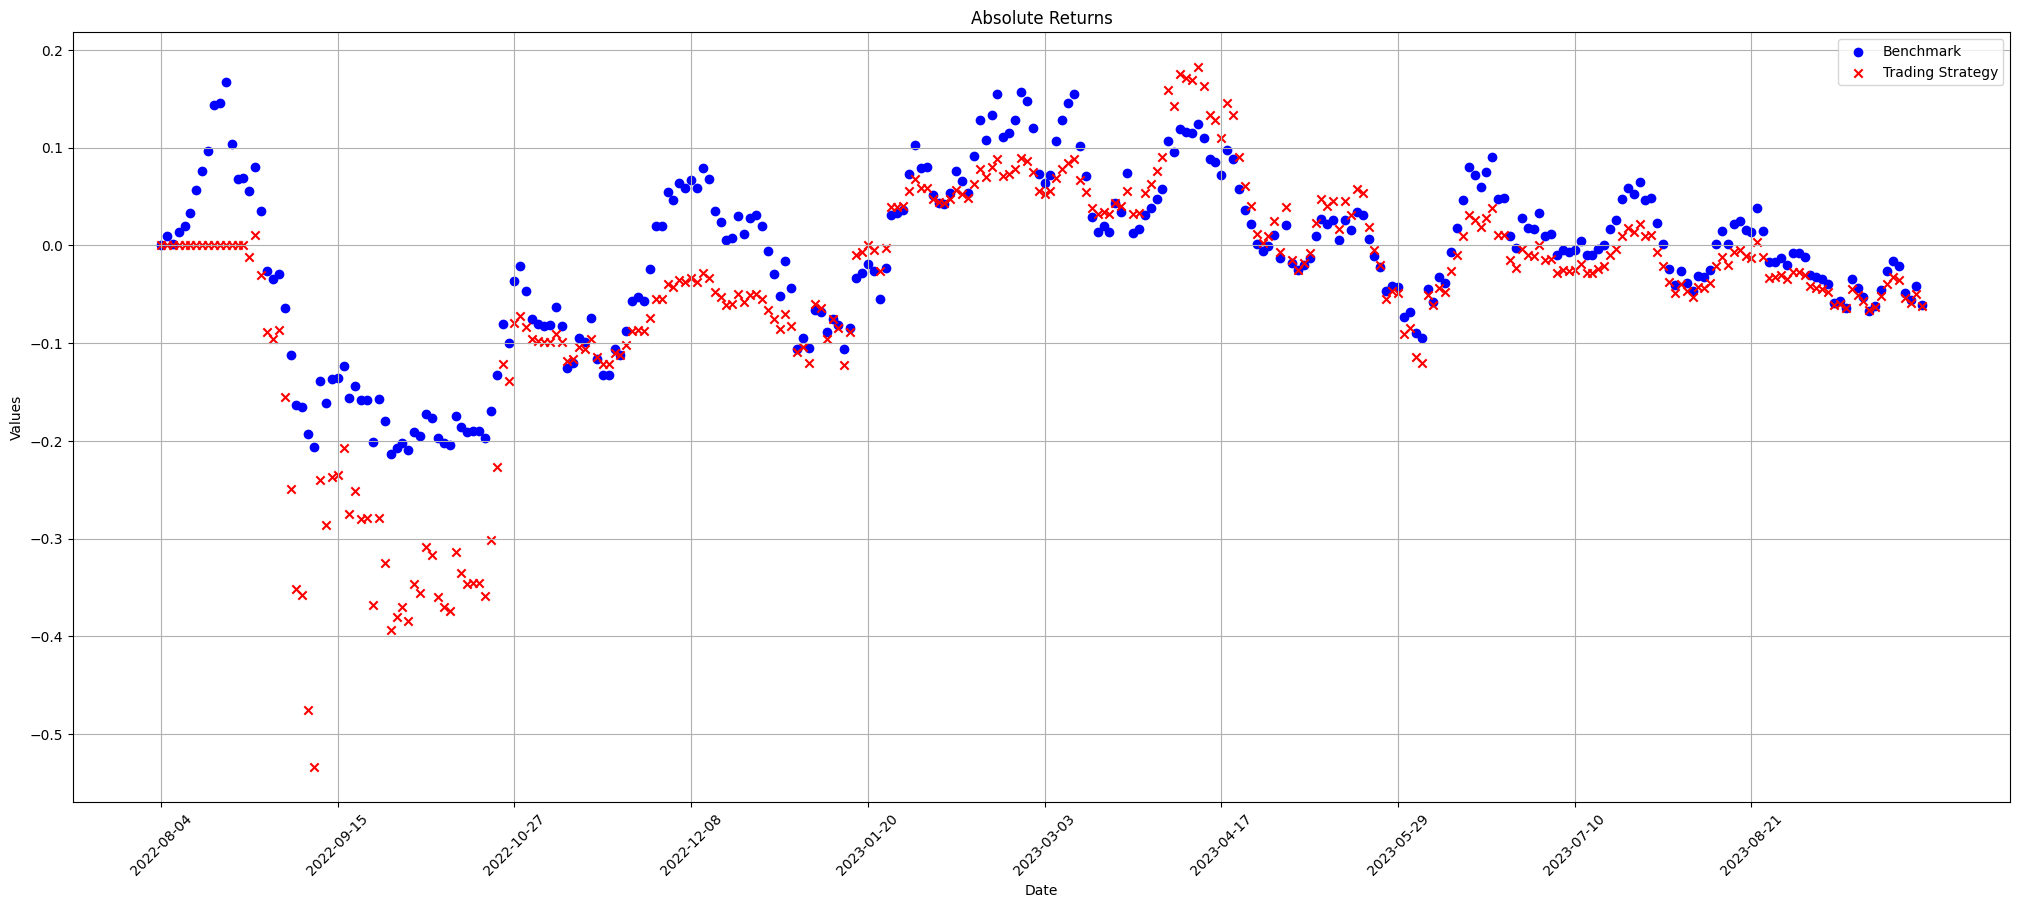

In [836]:
# Assuming 'Date' is a datetime column in your DataFrame
plt.figure(figsize=(25, 10))

# Scatter plot for 'BM AbsReturn' and 'TS AbsReturn'
plt.scatter(df['Date'], df['BM AbsReturn'], label='Benchmark', color='blue', marker='o')  # Adjust color and marker style as needed
plt.scatter(df['Date'], df['TS AbsReturn'], label='Trading Strategy', color='red', marker='x')  # Adjust color and marker style as needed

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Absolute Returns')
plt.grid(True)
plt.legend()
x_indices = np.arange(0, len(df), 30)
plt.xticks(df['Date'][x_indices], rotation=45)

plt.show()


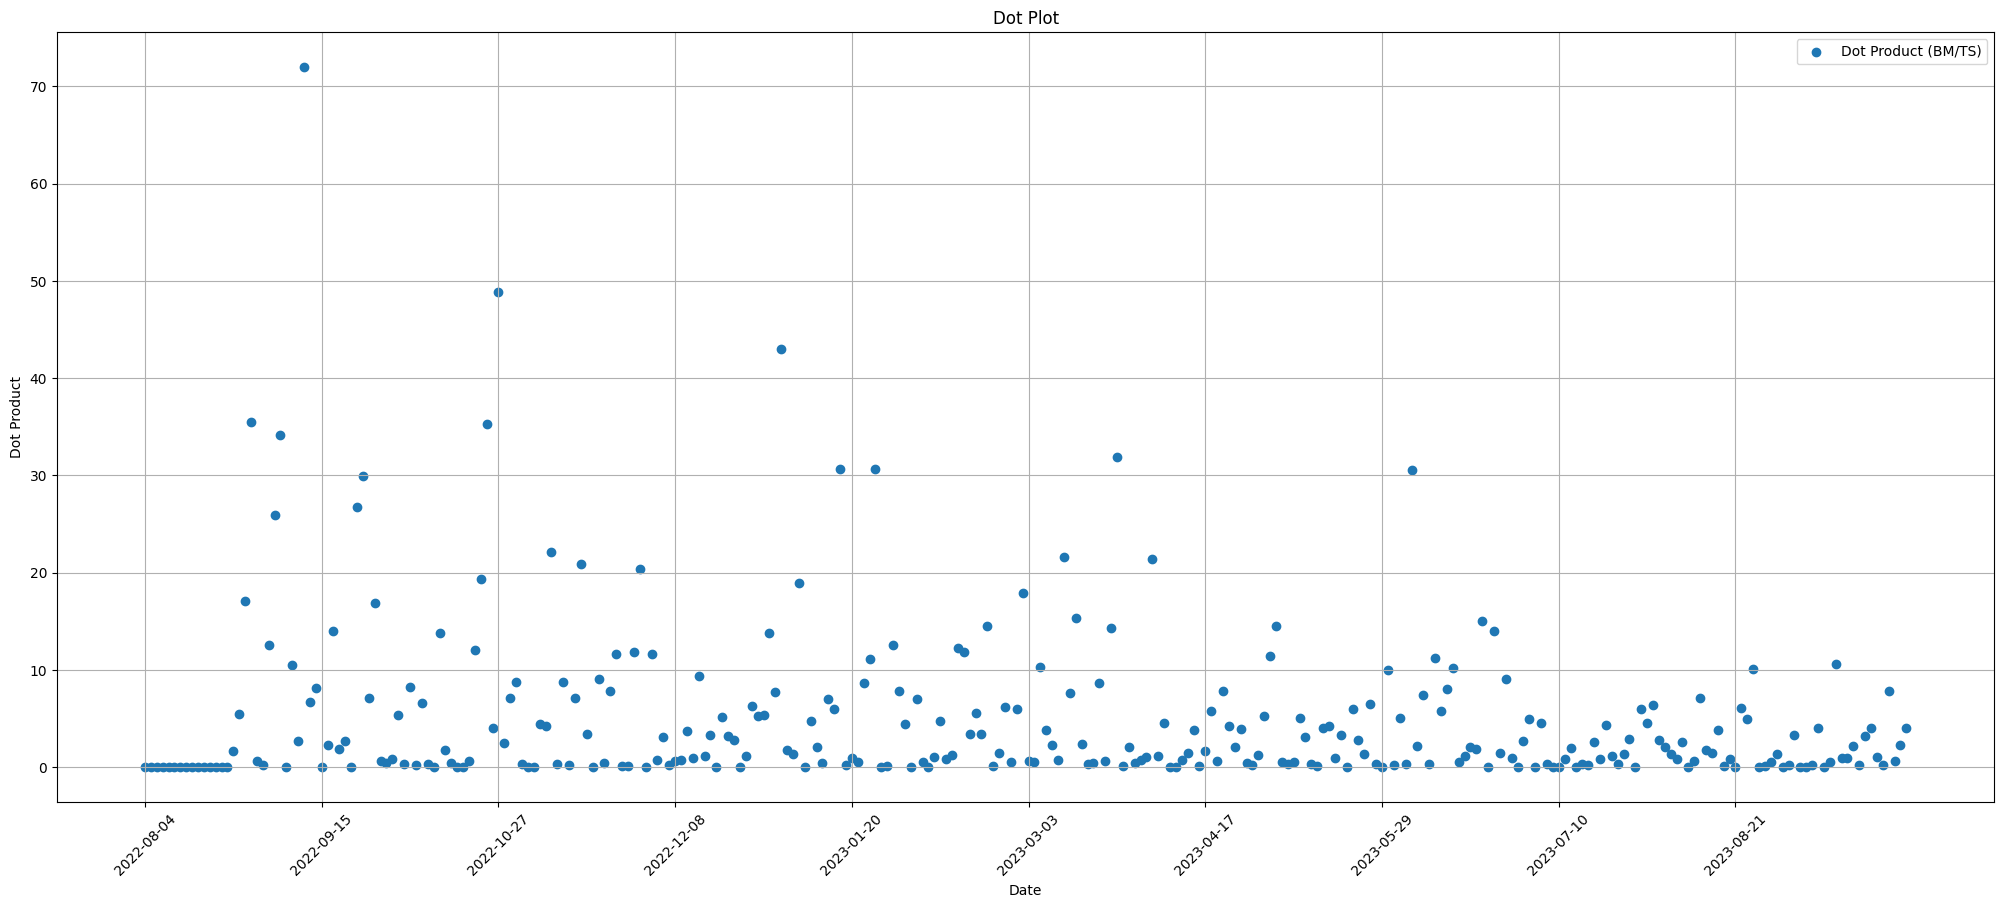

In [837]:
#Dot Plot

df['TS Dplot'] = (df['BM SReturn']*100)*(df['TS SReturn']*100)

# Assuming 'Date' is a datetime column in your DataFrame
plt.figure(figsize=(25, 10))
plt.scatter(df['Date'], df['TS Dplot'], label='Dot Product (BM/TS)')
plt.xlabel('Date')
plt.ylabel('Dot Product')
plt.title('Dot Plot')
plt.grid(True)
plt.legend()
x_indices = np.arange(0, len(df), 30)
plt.xticks(df['Date'][x_indices], rotation=45)

plt.show()

In [838]:
df.head(50)

,Open,High,Low,Close,MA,Smoothing Line,MA.1,Smoothing Line.1,MA.2,Smoothing Line.2,...,TS Gross Long,TS Gross Short,TS Netposition,BM SValue,BM SReturn,BM AbsReturn,TS SValue,TS SReturn,TS AbsReturn,TS Dplot
0,85.67,87.22,85.67,86.70,85.2762,85.13500,82.49225,82.23767,85.7586,85.74800,...,0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,86.69,87.80,86.31,87.56,85.3515,85.20542,82.62495,82.36448,85.7772,85.76304,...,0,0.0,0.0,1.009919,0.009919,0.009919,0.000000,0.000000,0.000000,0.000000
2,86.87,87.71,86.08,86.81,85.4077,85.27310,82.76005,82.49469,85.7898,85.77228,...,0,0.0,0.0,1.001269,-0.008566,0.001269,0.000000,0.000000,0.000000,-0.000000
3,86.86,88.58,86.42,87.92,85.4875,85.34482,82.90065,82.62821,85.8102,85.78408,...,0,0.0,0.0,1.014072,0.012787,0.014072,0.000000,0.000000,0.000000,0.000000
4,88.10,88.73,86.90,88.40,85.5648,85.41754,83.05310,82.76620,85.8012,85.78740,...,0,0.0,0.0,1.019608,0.005460,0.019608,0.000000,0.000000,0.000000,0.000000
5,88.19,90.50,88.05,89.60,85.6426,85.49082,83.19845,82.90744,85.8148,85.79864,...,0,0.0,0.0,1.033449,0.013575,0.033449,0.000000,0.000000,0.000000,0.000000
6,89.69,91.73,89.63,91.65,85.7816,85.57684,83.35225,83.05290,85.8510,85.81340,...,0,0.0,0.0,1.057093,0.022879,0.057093,0.000000,0.000000,0.000000,0.000000
7,91.52,93.50,91.20,93.32,85.9130,85.67790,83.51395,83.20368,86.0184,85.85912,...,0,0.0,0.0,1.076355,0.018221,0.076355,0.000000,0.000000,0.000000,0.000000
8,92.81,95.30,92.79,95.08,86.0619,85.79278,83.68690,83.36093,86.2468,85.94644,...,0,0.0,0.0,1.096655,0.018860,0.096655,0.000000,0.000000,0.000000,0.000000
9,95.00,99.22,95.00,99.18,86.2333,85.92648,83.87475,83.52526,86.5694,86.10008,...,0,0.0,0.0,1.143945,0.043122,0.143945,0.000000,0.000000,0.000000,0.000000
